# BDA Project
- Romain Claret
- Jämes Ménétrey
- Damien Rochat

### Load PySpark

In [1]:
import os
import findspark
findspark.init()

import pyspark

memory = '4g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["SPARK_HOME"] = "/opt/spark"
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

from pyspark import SparkContext
sc = SparkContext(appName="bda-spark")

In [2]:
#SparkContext.setSystemProperty('spark.executor.memory', '4g')
#SparkContext.setSystemProperty('spark.driver.memory', '40g')
#SparkContext.setSystemProperty('spark.driver.maxResultSize', '10g')
#SparkContext.setSystemProperty('spark.executor.memory', '4g')
#SparkContext.setSystemProperty('spark.executor.memory', '4g')
#conf = SparkConf().setAppName("bda-spark")
#conf = (conf.setMaster('local[*]')
#        .set('spark.executor.memory', '4G')
#        .set('spark.driver.memory', '45G')
#        .set('spark.driver.maxResultSize', '10G'))
#sc = SparkContext(conf=conf)

In [3]:
sc._conf.getAll()

[('spark.app.id', 'local-1559699432163'),
 ('spark.driver.memory', '4g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'rclaret.tic.heia-fr.ch'),
 ('spark.app.name', 'bda-spark'),
 ('spark.driver.port', '38031'),
 ('spark.ui.showConsoleProgress', 'true')]

### Check if Spark is working with a little PI calculation using monte carlo

In [4]:
import random
num_samples = 100000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.14636


### Load the Dataset

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [6]:
def df_maker(file_path):
    print(file_path)
    return (sqlContext.read.format("csv")
                .option("delimiter", ",")
                .option("header", "true")
                .load(file_path)
                .drop("medallion")
                .drop(" hack_license")
                .drop("hack_license")
                .withColumnRenamed(" vendor_id", "vendor_id")
                .withColumnRenamed(" rate_code", "rate_code")
                .withColumnRenamed(" store_and_fwd_flag", "store_and_fwd_flag")
                .withColumnRenamed(" pickup_datetime", "pickup_datetime")
                .withColumnRenamed(" dropoff_datetime", "dropoff_datetime")
                .withColumnRenamed(" passenger_count", "passenger_count")
                .withColumnRenamed(" trip_time_in_secs", "trip_time_in_secs")
                .withColumnRenamed(" trip_distance", "trip_distance")
                .withColumnRenamed(" pickup_longitude", "pickup_longitude")
                .withColumnRenamed(" pickup_latitude", "pickup_latitude")
                .withColumnRenamed(" dropoff_longitude", "dropoff_longitude")
                .withColumnRenamed(" dropoff_latitude", "dropoff_latitude")
           )

### Filter the Dataset

In [7]:
def df_filter(df):
    return (df.withColumn('pickup_longitude', df['pickup_longitude'].cast('float')) #convert str to float
          .withColumn('pickup_latitude', df['pickup_latitude'].cast('float'))
          .withColumn('dropoff_longitude', df['dropoff_longitude'].cast('float'))
          .withColumn('dropoff_latitude', df['dropoff_latitude'].cast('float'))
          .withColumn('trip_distance', df['trip_distance'].cast('float'))
          .filter(df.trip_distance<20.0) #filter out long distance, miles
          .na.drop() #removes rows with null
         )

### Create complete Dataframe from all Dataset files

In [8]:
path_trip = "datasets/trip_data/"
for idx,e in enumerate(os.listdir(path_trip)):
    if idx == 0:
        print("in 0",e)
        dff = df_filter(df_maker(path_trip+e))
        #break
    else:
        #print(e)
        df = df_filter(df_maker(path_trip+e))
        #print(df.columns)
        dff=dff.union(df)
        #break
    #print(dff.count()) #to comment in prod, very time consuming
dff.show(5)

in 0 trip_data_9.csv
datasets/trip_data/trip_data_9.csv
datasets/trip_data/trip_data_2.csv
datasets/trip_data/trip_data_11.csv
datasets/trip_data/trip_data_7.csv
datasets/trip_data/trip_data_5.csv
datasets/trip_data/trip_data_4.csv
datasets/trip_data/trip_data_1.csv
datasets/trip_data/trip_data_8.csv
datasets/trip_data/trip_data_10.csv
datasets/trip_data/trip_data_12.csv
datasets/trip_data/trip_data_6.csv
datasets/trip_data/trip_data_3.csv
+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-

#### Count of the whole dataset

In [9]:
dff.count()

86322541

#### Count of the unique last dataset load

In [10]:
df.count()

7901193

### Temporary Dataframes

In [11]:
dff_copy = dff
df_copy = df

## Using K-Means to show Clusters
- pickup cluster
- dropoff cluster

### Vecorizing the Dataframe

In [12]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="features")
vec_df_copy = vecAssembler.transform(df_copy)

### Fititng K-Means Model

In [13]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=15, seed=1) 
model = kmeans.fit(vec_df_copy.select('features'))

### Vecorizing and Clustering pickup clusters

In [14]:
vecAssembler = VectorAssembler(inputCols=["pickup_latitude", "pickup_longitude"], outputCol="features")
df_features_pickup = vecAssembler.transform(df_copy)
df_copy = model.transform(df_features_pickup)

### Cleaning and Assigning prediction as pickup cluster

In [15]:
df_copy = df_copy.withColumnRenamed('prediction', 'pickup_cluster')
df_copy = df_copy.drop('features')

### Vecorizing and Clustering dropoff

In [16]:
vecAssembler = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="features")
df_features_dropoff = vecAssembler.transform(df_copy)
df_copy = model.transform(df_features_dropoff)

### Cleaning and Assigning prediction as dropoff cluster

In [17]:
df_copy = df_copy.withColumnRenamed('prediction', 'dropoff_cluster')
df_copy = df_copy.drop('features')

## Let's plot it
### First step is to convert it to Panda Dataframe

In [18]:
pd_df = df_copy.toPandas()

In [19]:
pd_df = pd_df.sample(frac= 0.1)

### Cluster it with Seaborn

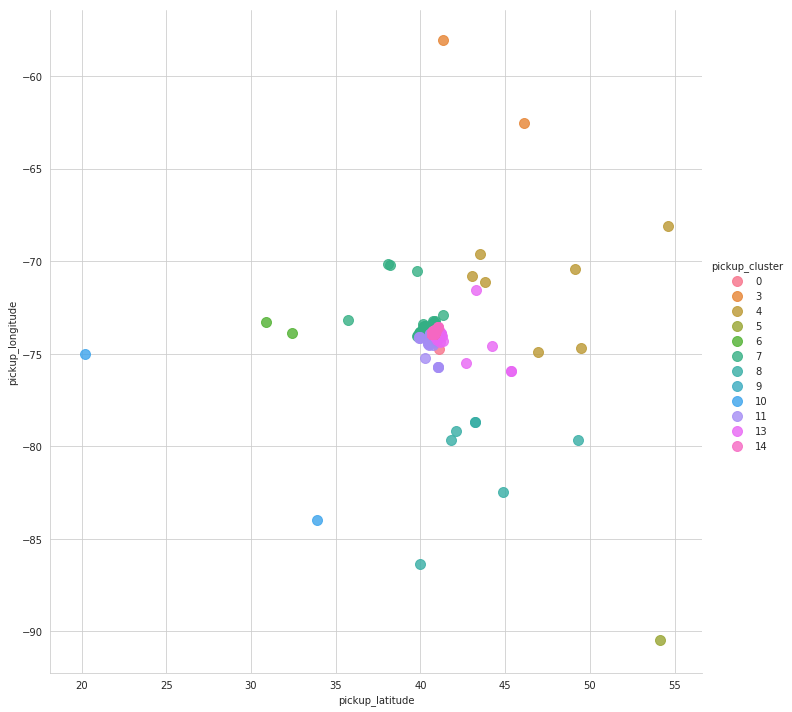

In [20]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="pickup_latitude", y="pickup_longitude",data = pd_df[pd_df['pickup_latitude']!=0.0],fit_reg=False,hue='pickup_cluster',height=10,scatter_kws={"s":100})

In [21]:
pd_df["pickup_cluster"].shape

(790119,)

In [22]:
pd_df["dropoff_cluster"].shape

(790119,)

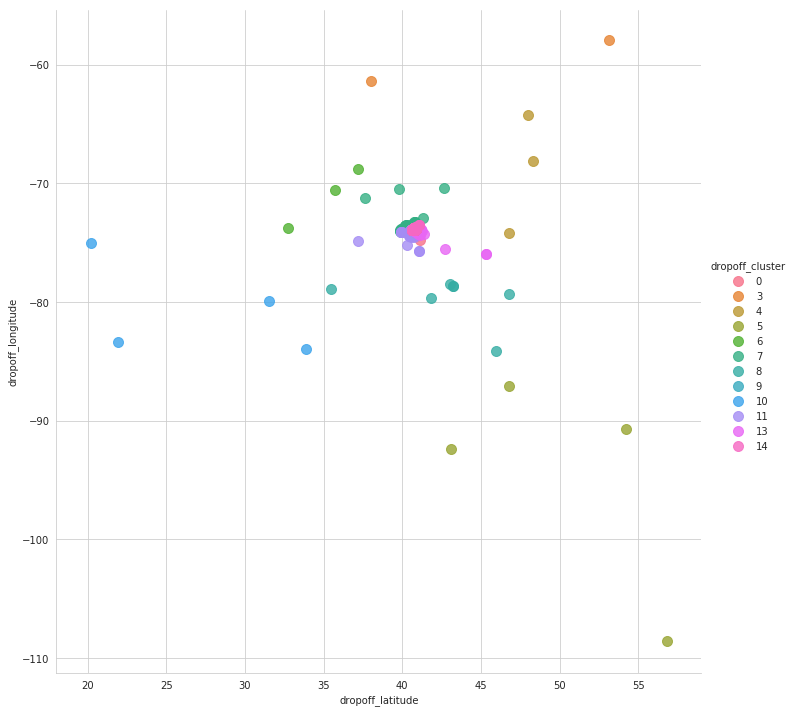

In [23]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.lmplot(x="dropoff_latitude", y="dropoff_longitude",data = pd_df[pd_df['dropoff_latitude']!=0.0],fit_reg=False,hue='dropoff_cluster',height=10,scatter_kws={"s":100})

In [24]:
#sc.stop()